In [1]:
import re
import numpy as np
import pandas as pd
import csv
from pprint import pprint
import math

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.corpora.dictionary import Dictionary



# Plotting tools
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

/home/flokla/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
#load training Data
with open('/home/flokla/Dropbox/Desktop/bachelorarbeit/realshit/Datasets/20NG_short/idocnade/training.csv', newline='') as csvfile1:
     data_train = pd.read_csv(csvfile1,  names=["Label", "Text"])    

#load validation Data
with open('/home/flokla/Dropbox/Desktop/bachelorarbeit/realshit/Datasets/20NG_short/idocnade/validation.csv', newline='') as csvfile2:
     data_val = pd.read_csv(csvfile2,  names=["Label", "Text"])    

frames = [data_train,data_val]
train_data = pd.concat(frames)

#load testing Data
with open('/home/flokla/Dropbox/Desktop/bachelorarbeit/realshit/Datasets/20NG_short/idocnade/test.csv', newline='') as csvfile3:
     data_test = pd.read_csv(csvfile3,  names=["Label", "Text"])  
   

In [3]:
def LdaPipeline(train_fold, val_fold, k):

    dictionary = gensim.corpora.Dictionary(train_fold["Text"].str.split())
    corpus_train = [dictionary.doc2bow(text.split()) for index,text in train_fold["Text"].iteritems()]
    corpus_val = [dictionary.doc2bow(text.split()) for index,text in val_fold["Text"].iteritems()]
    # LDA
    lda_model = gensim.models.LdaMulticore(corpus=corpus_train, id2word = dictionary, num_topics = k, alpha=0.1,workers=15)
    
    # Perplexity
    perplexity = lda_model.log_perplexity(corpus_val)
   
    # Coherence
    texts = [[dictionary[word_id] for word_id, freq in doc] for doc in corpus_val]
    coherence_model = gensim.models.coherencemodel.CoherenceModel(model=lda_model, corpus=corpus_train, texts = texts,coherence='c_v')
    coherence = coherence_model.get_coherence()
    
    """
    from sklearn.datasets import fetch_20newsgroups
    newsgroups_train = fetch_20newsgroups(subset='train')
    label_mapping = dict()
    i = 0
    for word in newsgroups_train.target_names:
        label_mapping[word]=i
        i+=1
        
    corpus_labels = np.ndarray(np.array([label_mapping[y] for y in train_fold["Label"]]))
    query_labels= np.ndarray([label_mapping[y] for y in val_fold["Label"]])
    
    ir_eval = evaluate(
    corpus_train,
    corpus_val,
    corpus_labels,
    query_labels,
    recall=[0.02],
    num_classes=k,
    query_docs=None,
    corpus_docs=None,
    IR_filename=""
)"""
    return [2**(-perplexity), coherence]#, ir_eval]



In [4]:
START = 2
STEP = 1
END = 200


In [5]:
#generate different LDA-Models
coherence_values = []
ppl_values = []
for k in tqdm(range(START, END, STEP)):
    ppl, cv = LdaPipeline(data_train,  data_val,k)
    coherence_values.append(cv)
    ppl_values.append(ppl)

/home/flokla/anaconda3/lib/python3.8/site-packages/gensim/topic_coherence/direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  m_lr_i = np.log(numerator / denominator)
/home/flokla/anaconda3/lib/python3.8/site-packages/gensim/topic_coherence/indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in double_scalars
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


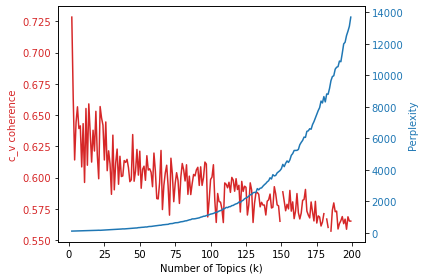

In [6]:
# Show graph

x = range(START, END, STEP)
fig, ax1 = plt.subplots()
#ppls = [math.exp(p) for p in ppl_values]

color = 'tab:red'
ax1.set_xlabel('Number of Topics (k)')
ax1.set_ylabel('c_v coherence', color=color)
ax1.plot(x, coherence_values, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Perplexity', color=color)  
ax2.plot(x, ppl_values, color=color) #use ppls instead of ppl_values for true Perplexity instead of lower bound
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
plt.show()

In [7]:
maxvalue = max(coherence_values)
print("Maximum Coherence_Value in the list is:", maxvalue)
#Now we have find the position of Max Value
maxpos = coherence_values.index(maxvalue)
print("This value is achieved when using k = "+str(2+maxpos)+" topic-clusters")

Maximum Coherence_Value in the list is: 0.7284666391511816
This value is achieved when using k = 2 topic-clusters


In [11]:
# Evaluate Model with best hyperparameter for k
ppl0, cv0 = LdaPipeline(train_data,  data_test,14)
print("Perplexity: "+str(ppl0)+" and Coherence: "+str(cv0))    


### for COMPARISON with other setups
ppl1, cv1 = LdaPipeline(train_data,  data_test,20)
print("k = 20; Perplexity: "+str(ppl1)+" and Coherence: "+str(cv1)) 

ppl2, cv2 = LdaPipeline(train_data,  data_test,50)
print("k= 50; Perplexity: "+str(ppl2)+" and Coherence: "+str(cv2)) 

ppl3, cv3 = LdaPipeline(train_data,  data_test,100)
print("k = 100; Perplexity: "+str(ppl3)+" and Coherence: "+str(cv3)) 

ppl4, cv4 = LdaPipeline(train_data,  data_test,200)
print("k = 200; Perplexity: "+str(ppl4)+" and Coherence: "+str(cv4)) 

Perplexity: 122.60893621079735 and Coherence: 0.6460186963580382
k = 20; Perplexity: 130.86170406391318 and Coherence: 0.6232434973590444
k= 50; Perplexity: 174.8535253771406 and Coherence: 0.6221240640866837
k = 100; Perplexity: 281.41472801351637 and Coherence: 0.6137659765384481
k = 200; Perplexity: 700.2560274757388 and Coherence: 0.5900048157098352


In [12]:
### visualize all results
from astropy.table import QTable, Table, Column
from astropy import units as u

data_rows = [(14, ppl0, cv0),
             (20, ppl1, cv1),
             (50, ppl2, cv2),
             (100, ppl3, cv3),
             (200, ppl4, cv4)]
t = Table(rows=data_rows, names=('k', 'Perplexity', 'Coherence c_v'))
print(t)

 k      Perplexity       Coherence c_v   
--- ------------------ ------------------
 14 122.60893621079735 0.6460186963580382
 20 130.86170406391318 0.6232434973590444
 50  174.8535253771406 0.6221240640866837
100 281.41472801351637 0.6137659765384481
200  700.2560274757388 0.5900048157098352


In [17]:
ppl, cv, ir = LdaPipeline(train_data,  data_test,20)
print("k = 20; Perplexity: "+str(ppl4)+" and Coherence: "+str(cv4)+" and IR: "+str(ir)) 

ValueError: maximum supported dimension for an ndarray is 32, found 11314

In [11]:
import sklearn.metrics.pairwise as pw
### perform IR ###
def evaluate(
    corpus_vectors,
    query_vectors,
    corpus_labels,
    query_labels,
    recall=[0.02],
    num_classes=None,
    query_docs=None,
    corpus_docs=None,
    IR_filename=""
):
    
    corpus_size = len(corpus_labels)
    query_size = len(query_labels)

    results = []
    for r in recall:
        n_docs = int((corpus_size * r) + 0.5)
        if not n_docs:
            results.append(0.0)
            continue

        closest = closest_docs_by_index(corpus_vectors, query_vectors, n_docs)

        avg = 0.0
        for i in range(query_size):
            doc_labels = query_labels[i]
            doc_avg = 0.0
            for label in doc_labels:
                doc_avg += precision(label, corpus_labels[closest[i]])
            doc_avg /= len(doc_labels)
            avg += doc_avg
        avg /= query_size
        results.append(avg)
    return results

def closest_docs_by_index(corpus_vectors, query_vectors, n_docs):
    docs = []
    sim = pw.cosine_similarity(corpus_vectors, query_vectors)
    order = np.argsort(sim, axis=0)[::-1]
    for i in range(len(query_vectors)):
        docs.append(order[:, i][0:n_docs])
    return np.array(docs)

def precision(label, predictions):
    if len(predictions):
        return float(
            len([x for x in predictions if label in x])
        ) / len(predictions)
    else:
        return 0.0


In [10]:
i=2
for val in coherence_values:
    print(str(i)+": "+str(val))
    i+=1

2: 0.7284666391511816
3: 0.6635122524616474
4: 0.6141675324006702
5: 0.6441568831447194
6: 0.6566838041306201
7: 0.6393052946804963
8: 0.6414317944258465
9: 0.608591487050465
10: 0.6432081416366404
11: 0.5961671429622405
12: 0.6553429783828681
13: 0.6099238380135089
14: 0.6590226951562214
15: 0.6350037096274989
16: 0.6124488694543929
17: 0.6379446259033115
18: 0.6213036701368574
19: 0.6530860917435457
20: 0.6182733967974181
21: 0.5991091163750436
22: 0.6568932479828841
23: 0.6477876069739745
24: 0.6420594408289871
25: 0.6141395729212514
26: 0.6445638359402663
27: 0.605573108228245
28: 0.6214647524245526
29: 0.6109752506765616
30: 0.5866550826031726
31: 0.6340098847130331
32: 0.5902375279196824
33: 0.6118581208186658
34: 0.622871655703329
35: 0.5947028357142541
36: 0.6171077091065712
37: 0.6009024121046666
38: 0.6013680590503845
39: 0.6136669251508546
40: 0.6121973401700493
41: 0.6146402671353354
42: 0.6080528610096891
43: 0.5967802829810446
44: 0.5982363427365556
45: 0.6344860685104586